* being provoked by goodfellow's chapter on probability theory to try out pytorch
* he gives a very clean framework... that one might use!

* we try to organize our own heads - by trying to introduce r.v. and probability distributions - leveraging python

## utils

* making some utils for drawing probability distributions

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
from torch import distributions as dist
from torch import tensor, ones, zeros, arange, linspace
import torch
from functools import partial

from torch.distributions.constraints import \
        Constraint, \
        _Real, _Interval, _IntegerInterval, \
        _GreaterThan, _GreaterThanEq

from torch.distributions import constraints


In [180]:
def plot_distribution(distribution: dist.Distribution, support: list, ax:plt.Axes = None):
    
    probabilities = distribution.log_prob(torch.tensor(support)).exp().numpy()
    
    ax = ax or plt.gca()
    ax.set_title(f"Probability distribution of {distribution.__class__.__name__}")
    ax.plot(support, probabilities, 's')
    ax.vlines(support, 0, probabilities, lw=1)

def countplot_of_sample(distribution: dist.Distribution, size: int = 100, ax:plt.Axes = None):
    sample = distribution.sample((size,)).numpy()
    
    ax = ax or plt.gca()
    ax.set_title(f"Countplot of sample with size={size}")
    sns.countplot(x=sample, ax=ax)

def histogram_of_sample(distribution: dist.Distribution, size: int = 100, ax:plt.Axes = None):
    sample = distribution.sample((size,)).numpy()
    
    ax = ax or plt.gca()
    ax.set_title(f"Histogram of sample with size={size}")
    sns.histplot(x=sample, ax=ax, stat="density", kde=True)
    

def picture_distribution(distribution: dist.Distribution, support: list, discrete: bool, ax:plt.Axes = None):
    
    sample_plotting = countplot_of_sample if discrete else histogram_of_sample
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plot_distribution(distribution, support, ax=ax1)
    sample_plotting(distribution, ax=ax2)
    ax2.set_xlim(ax1.get_xlim())

## probability distributions

* random variables are just variables that may take on different values, and of which one does not know the actual value in advance
* instead, they are defined by association with a probability distribution:
    * the probability attributed to each possible value - in discrete cases (dubbed PMF); or
    * the probability attributed to each possible range of values - in continuous cases (dubbed PDF)
* the probability distribution is thus a function - some mapping - which we'll name $p$ -with few restrictions that come as a simple consequence of the axioms of probability theory (in either presentation)
    

* probability theory gives a set of axioms for dealing with probability on any given statements $A, B, H$, and any given partition statements $E_1, E_2, ..., E_n$ (i.e., a mutually exclusive and comprehensive set of statements):
    * _absorbent value_'s convention: $0 \leq P(A)$
    * _normalized values_' convention: $P(A) \leq 1$
    * _product rule_: $P(A, B) = P(A|B)P(B)$, or $P(A, B|H) = P(A|B,H)P(B,H)$
    * _sum rule_: $P(A \text{ or } B) = P(A) + P(B) - P(A,B)$
    * _partition rule_: $P(A) = \sum P(A, E_i)$

* for our r.v. case (be it unidimensional or not..), we get:
    * $\forall x, p(x) \geq 0$
    * $\sum_i p(x_i) = 1$, or $\int_x p(x) = 1$

* and for joint distributions:
    * $p(x, y) = p(x|y)p(y)$
    * $p(x) = \sum_y p(x,y)$, or $\int p(x,y) dy$

* an important definition is for *2 r.v. to be independent* - which corresponds to common-sense - taking when:
    * $p(x|y) = p(x)$, or, equivalently, 
    * $p(x,y) = p(x)p(y)$

* naturally, if one r.v. is cast as a function of another, aka $Y = f(X)$ for some $f$,
    * then the probability distribution of $Y$ is also a function of the probability for $X$ (it just might be a weird one - and not as direct - some inverse relationship)
    * given that it satisfies some general properties that most of our well behaved famous functions will do - and we won't search for!

* more so, for the distributions of r.v. associated with constructive assumptions (such as: the r.v. corresponding to the number of successes in a sequence of independent trials),
    * one should be able to leverage the assumptions - using probability theory - to turn them into quantitative statements about the probability distribution
* in doing so, one would arrive at a simpler expression for the probability distribution - i.e.:
    * one can write the function as an expression of the value and some associated _sufficient statistics_ (aka _parameters)
    * these _sufficient statistics_ basically represent some minimal information for fully describing the expression of the probability distribution

* possibly the most important principal for turning such qualitative assumptions into quantitative expressions is:
    * the ***principle of maximum entropy*** - which states that, given only a set of constraints, one should 
        * choose the probability distribution with the highest entropy - or, in other words, 
        * choose the probability distribution which entails the least further constraints

### discrete variables

so, discrete r.v.'s are either:
* finite, in the case of $X \in \{x_1, \dots, x_n\}$
* infinite (yet countable), in the case of $X \in \{x_i: i \in \mathbb{N}\}$

#### finite support

##### **Categorical**

* having a finite support, the **general case** (on which one is to specify the probability of each possibility) goes by the name of _Categorical_ or _Multinoulli_ distribution

* one such distribution is fully described by describing the probability of each possible value - its sufficient statistics/parameters are the actual probabilities - sometimes dubbed $\theta_1, ..., \theta_n$, for $X \in {1, ..., n}$

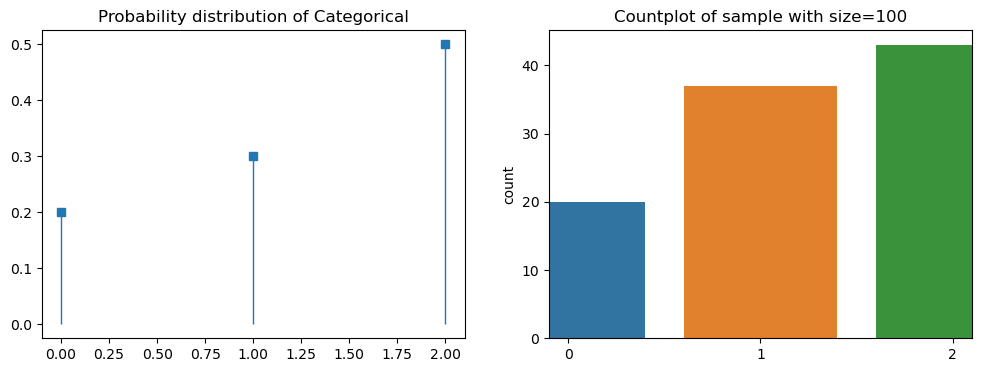

In [181]:
X_cat = dist.Categorical(probs=tensor([0.2, 0.3, 0.5]))
picture_distribution(X_cat, [0, 1, 2], discrete=True)

* well, some of the categorical distributions are special enough that they deserve their own name
* in which sense - _special_?
    * they have a generating procedure from which they are fully specified
    * which simplifies the amount of information/parameters needed to specify the distribution
    * one instead knows the probability as an expression of the value and the distribution's sufficient statistics

##### **Bernoulli**

* ***when we care about a binary variable***

* basically any r.v. with only 2 possible values $\{x_1, x_2\}$ may be cast as a Bernoulli distribution
    * when one equates $x_1 \rightarrow 0$ and $x_2 \rightarrow 1$
    * we may only care about the probability of $x_2$, aka $P(X=1)$, aka $p$, aka $\theta$, etc
        * since $P(X=0) = 1 - P(X=1) = 1 - p$
    * and name $x_2$ as our _success_, accordingly (!)

* if one so wishes, she can write:
    * $X \sim Bernoulli(p)$
    * $p(X) = p^X (1 - p)^{1 - X}$, in order to get a fully specified expression

* bernoulli has many children

##### **Binomial**

* ***when one cares about counting the number of successes in $n$ independent and binary trials***

* if one names the number of trials as $n$,
* then the support is the set of all possible outcomes, i.e. $\{0, 1, \dots, n\}$

* if one wanted to argue out the probability of each possible outcome, based on the independence statement, the implied statement behind _success_, and the principle of maximum entropy
    * one could! - no interest now

* $X \sim Binomial(n, p)$
* $p(X) = \binom{n}{X}p^X (1-p)^{n-X}$

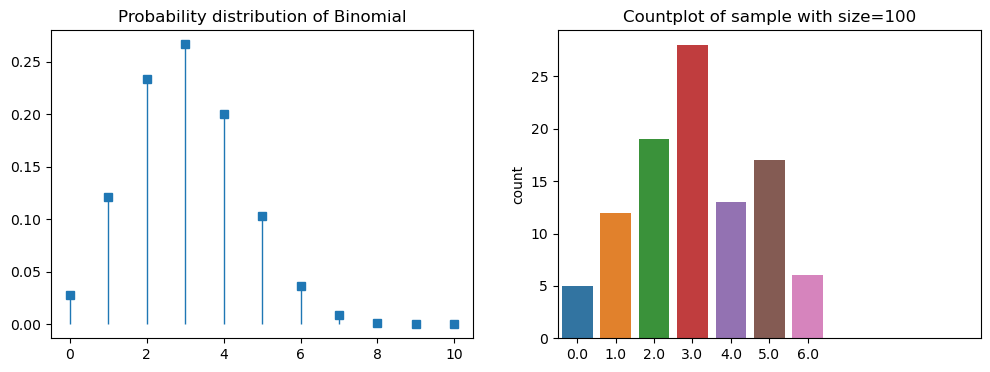

In [182]:
p, n = 0.3, 10
X_binomial = dist.Binomial(n, p)
support = list(range(0, n+1))

picture_distribution(X_binomial, support, discrete=True)

##### **HyperGeometric**

* ***when modelling the number of successes out of $n$ exhaustable trials with $m$ successes***

* or, to give it some example, the number of red balls one extracts from a bag with 30 balls (12 of which are red),
    * when the bag is very well shuffled, and
    * the balls are extracted in sequence, and not replaced back into the bag (!)
* so, in other words, when we know how many "balls" there are in the bag.

In [183]:
# trying to extend torch's distribution
class HyperGeometric(torch.distributions.Distribution):
    
    
    arg_constraints = {
        'n': constraints.nonnegative_integer,
        'm': constraints.nonnegative_integer,
    }
    
    has_enumerate_support = True

    def __init__(self, n, m):
    
        self.n = torch.tensor(n)
        self.m = torch.tensor(m)
        super(HyperGeometric, self).__init__()
        
    @constraints.dependent_property(is_discrete=True, event_dim=0)
    def support(self):
        return constraints.integer_interval(0, min(self.n, self.m))
    

In [185]:
HyperGeometric(1,2)

HyperGeometric(n: 1, m: 2)

* bah - could be fun - but not for now

#### countable support

##### **Geometric**

* ***when modelling the number of trials until the first success***

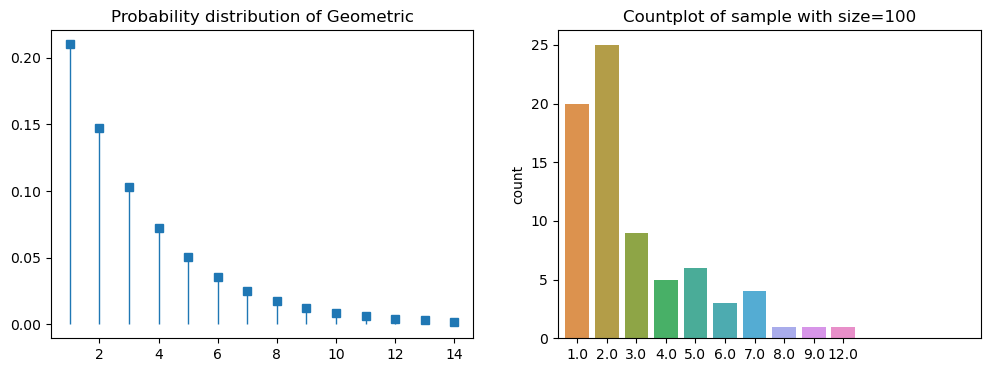

In [187]:
X_geom = dist.Geometric(0.3)
support = list(range(1, 15))
picture_distribution(X_geom, support, discrete=True)

##### **Negative Binomial**

* ***when modelling the number of trials before $k$ failures***

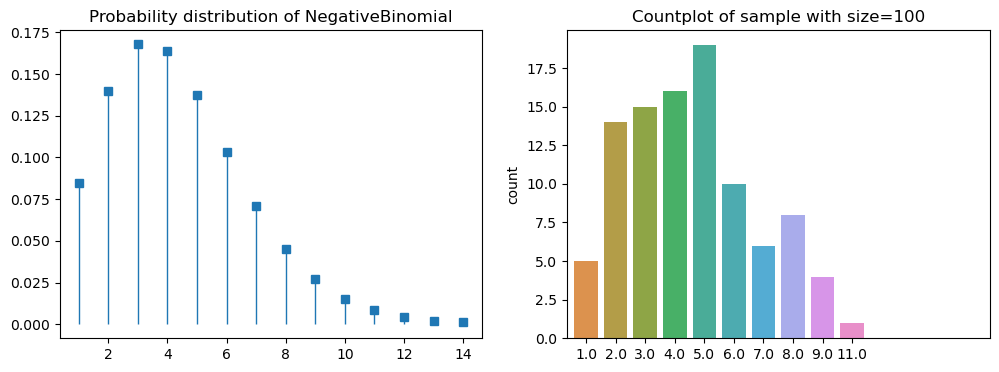

In [199]:
k, p = 10, 0.3
X_geom = dist.NegativeBinomial(k, p)
support = list(range(1, 15))
picture_distribution(X_geom, support, discrete=True)

##### **Poisson**

* when modelling the number of successes in a fixed time interval, when
    * if the events occur with a known constant _mean rate_ (aka $\lambda$), 
    * and independently of the time since the last event.

* poisson may be seen as a limit of binomial distribution (whose parameter $\lambda$ corresponds to $np$), when $n$ tends to infinity

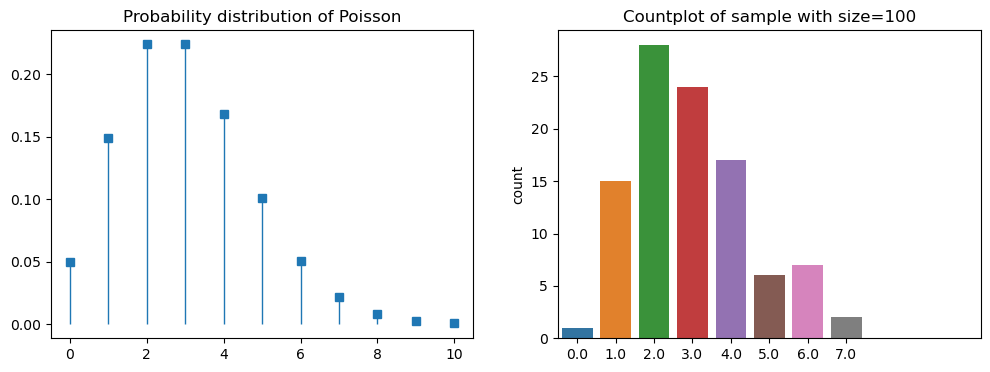

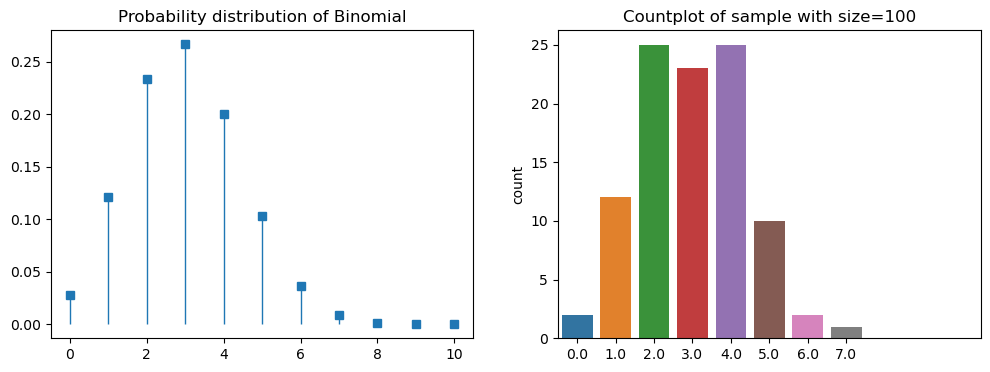

In [204]:
n, p = 10, 0.3
lambda_ = n * p

X_poisson = dist.Poisson(lambda_)
support = list(range(0, 11))
picture_distribution(X_poisson, support, discrete=True)

X_binomial = dist.Binomial(n, p)
picture_distribution(X_binomial, support, discrete=True)

### continuous distributions

#### the exponential family

#### other important distributions

---

* this should be continued in a proper file!